# SPTAlign: subpixel registration using single-particle-tracking data


## Objective

The objective is to correct for subpixel drifts in a traction force microscopy image timeseries (fluorescent beads, a tiny fraction of which are moved by cells). Without the correction, the use of optical flow methods such as PIV is too noisy.


## Prerequisite

* an image stack saved frame by frame with the frame number in each filename (see the folder data for a provided demo stack)
* Fiji with a working TrackMate (in any case we provide a tracking table for the demo stack)
* the requirements of `spt_align` to be available in the Python environment

# 1) Track the spots with TrackMate

Open your stack in Fiji. Calibrate spatially the stack (`Ctrl+Shift+P`, then set `Pixel width` and `Pixel height`). For the demo, set these values to 1 µm. 

Go to `Plugins > Tracking > TrackMate`. Follow the steps to track your fluorescent beads.

Select the LoG detector, put the `Quality threshold` to zero and set the `Estimated object diameter` first. On the demo movie, set `Estimated object diameter` to 4 µm and then increae the `Quality threshold` to 13. Disable the `Pre-process with median filter` option and activate the `Sub-pixel localization`.

Keep pressing next until the selection of the tracker. Select the `Simple LAP tracker`. Set the `Linking max distance` to the spot diameter. The demo contains blurred frames and a black frame. To jump over these, it is necessary to increase the `Gap-closing max frame gap` above 1 (set 5-8) and the `Gap-closing max distance` to the spot diameter size.

Click on next to visualize the result, color by track duration. Go back one step and tweak the `Simple LAP tracker` parameters if too many tracks are truncated. For the sake of the demo we purposefully performed a noisy tracking that can be found in the data folder.

# 2) Load the frames and tracks

In [1]:
from spt_align.io import load_tracks, locate_frames, estimate_timeline
import os

df = load_tracks(os.sep.join(['..','data','tracks_corrupted.csv']))
frames = locate_frames(os.sep.join(['..','data','images']))
timeline = estimate_timeline(frames, df)
print(f'Number of frames: {len(frames)}')
print(f'Maximum timepoint: {timeline[-1]}')
# CAREFUL TO SET THE SAME CALIBRATION AS IN THE TRACKING STEP
PxToUm = 1

Number of frames: 199
Maximum timepoint: 198


# 3) Estimate a first displacement profile with $t_{\textrm{ref}} = 0$

To estimate the displacement from $t_{\textrm{ref}} = 0$ to $T$, we can look at the track intersection between these two timepoints. If enough tracks are shared (meaning that there exists a position at both timepoints), we can fit a normal distribution to the distribution of -x and -y displacements. 

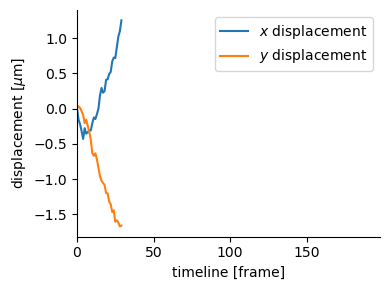

In [2]:
from spt_align import estimate_displacement, plot_displacement

displacement_0 = estimate_displacement(df, timeline, reference_time=0, nbr_tracks_threshold=30)
plot_displacement(timeline, displacement_0)

As you can see the estimated displacement stops early in the movie, around frame 30, meaning that no track from the first frame ($t_{\textrm{ref}} = 0$) survives past this point due to a poor tracking parameter choice. 

# 4) Move the reference time

Let's see how we can change the reference time to have displacement information at other timepoints. We can assume that the number of tracks at time $T - n$ existing at $T$ decays with $n$, on average. Therefore, a reasonable reference time could be $T-1$. If not enough tracks are found in common, we can try $T-2$ and so on, until reaching $0$. This approach is computationally long though since for each $T$, we will compute the displacement with $T-1$. The fact that more tracks are available at $T-1$ than any other time may not be good news either as the risk of false positive (noisy) tracks is also much higher.

If we reach zero, it means that changing the reference time does not fix our problem. The last thing we can do is extrapolate these missing displacements.

  0%|                                                   | 0/199 [00:00<?, ?it/s]

Time 30: No displacement with reference t=0 found... Attempt to change the reference...


 16%|██████▌                                   | 31/199 [00:03<00:18,  8.96it/s]

Time 30: Failed to find a valid reference time...
Time 31: No displacement with reference t=0 found... Attempt to change the reference...
Time 31: Failed to find a valid reference time...
Time 32: No displacement with reference t=0 found... Attempt to change the reference...


 17%|██████▉                                   | 33/199 [00:03<00:18,  8.98it/s]

Time 32: Failed to find a valid reference time...
Time 33: No displacement with reference t=0 found... Attempt to change the reference...


 17%|███████▏                                  | 34/199 [00:03<00:19,  8.52it/s]

Time 33: Failed to find a valid reference time...
Time 34: No displacement with reference t=0 found... Attempt to change the reference...


 18%|███████▍                                  | 35/199 [00:04<00:24,  6.71it/s]

Time 34: New reference time set to t=33...
Time 34: Displacement(t=33) not valid... Extrapolating this value...
Time 34: Displacement_x(t=33) = 1.8681062321498831
Total displacement_x = 1.8413651952626844
Time 35: No displacement with reference t=0 found... Attempt to change the reference...


 18%|███████▌                                  | 36/199 [00:05<00:30,  5.27it/s]

Time 35: New reference time set to t=34...
Time 35: Displacement_x(t=34) = 1.8413651952626844
Total displacement_x = 1.839051839739074
Time 36: No displacement with reference t=0 found... Attempt to change the reference...


 19%|███████▊                                  | 37/199 [00:05<00:38,  4.26it/s]

Time 36: New reference time set to t=35...
Time 36: Displacement_x(t=35) = 1.839051839739074
Total displacement_x = 1.7980542299900353
Time 37: No displacement with reference t=0 found... Attempt to change the reference...


 19%|████████                                  | 38/199 [00:06<00:45,  3.56it/s]

Time 37: New reference time set to t=36...
Time 37: Displacement_x(t=36) = 1.7980542299900353
Total displacement_x = 1.8366949778130885
Time 38: No displacement with reference t=0 found... Attempt to change the reference...


 20%|████████▏                                 | 39/199 [00:06<00:52,  3.05it/s]

Time 38: New reference time set to t=37...
Time 38: Displacement_x(t=37) = 1.8366949778130885
Total displacement_x = 1.8774933493581503
Time 39: No displacement with reference t=0 found... Attempt to change the reference...


 20%|████████▍                                 | 40/199 [00:07<00:58,  2.70it/s]

Time 39: New reference time set to t=38...
Time 39: Displacement_x(t=38) = 1.8774933493581503
Total displacement_x = 1.8959097552001196
Time 40: No displacement with reference t=0 found... Attempt to change the reference...


 21%|████████▋                                 | 41/199 [00:07<01:04,  2.45it/s]

Time 40: New reference time set to t=39...
Time 40: Displacement_x(t=39) = 1.8959097552001196
Total displacement_x = 1.864704806423143
Time 41: No displacement with reference t=0 found... Attempt to change the reference...


 21%|████████▊                                 | 42/199 [00:08<01:08,  2.28it/s]

Time 41: New reference time set to t=40...
Time 41: Displacement_x(t=40) = 1.864704806423143
Total displacement_x = 1.9096365508553181
Time 42: No displacement with reference t=0 found... Attempt to change the reference...


 22%|█████████                                 | 43/199 [00:08<01:11,  2.17it/s]

Time 42: New reference time set to t=41...
Time 42: Displacement_x(t=41) = 1.9096365508553181
Total displacement_x = 1.9345998674529346
Time 43: No displacement with reference t=0 found... Attempt to change the reference...


 22%|█████████▎                                | 44/199 [00:09<01:14,  2.09it/s]

Time 43: New reference time set to t=42...
Time 43: Displacement_x(t=42) = 1.9345998674529346
Total displacement_x = 2.00572435828087
Time 44: No displacement with reference t=0 found... Attempt to change the reference...


 23%|█████████▍                                | 45/199 [00:09<01:15,  2.04it/s]

Time 44: New reference time set to t=43...
Time 44: Displacement_x(t=43) = 2.00572435828087
Total displacement_x = 2.115854604268776
Time 45: No displacement with reference t=0 found... Attempt to change the reference...


 23%|█████████▋                                | 46/199 [00:10<01:16,  2.01it/s]

Time 45: New reference time set to t=44...
Time 45: Displacement_x(t=44) = 2.115854604268776
Total displacement_x = 2.1430113074351644
Time 46: No displacement with reference t=0 found... Attempt to change the reference...


 24%|█████████▉                                | 47/199 [00:10<01:16,  1.99it/s]

Time 46: New reference time set to t=45...
Time 46: Displacement_x(t=45) = 2.1430113074351644
Total displacement_x = 2.2086984735601165
Time 47: No displacement with reference t=0 found... Attempt to change the reference...


 24%|██████████▏                               | 48/199 [00:11<01:16,  1.98it/s]

Time 47: New reference time set to t=46...
Time 47: Displacement_x(t=46) = 2.2086984735601165
Total displacement_x = 2.210269774218981
Time 48: No displacement with reference t=0 found... Attempt to change the reference...


 25%|██████████▎                               | 49/199 [00:11<01:15,  1.98it/s]

Time 48: New reference time set to t=47...
Time 48: Displacement_x(t=47) = 2.210269774218981
Total displacement_x = 2.299111002113862
Time 49: No displacement with reference t=0 found... Attempt to change the reference...


 25%|██████████▌                               | 50/199 [00:12<01:15,  1.98it/s]

Time 49: New reference time set to t=48...
Time 49: Displacement_x(t=48) = 2.299111002113862
Total displacement_x = 2.3340815091060496
Time 50: No displacement with reference t=0 found... Attempt to change the reference...


 26%|██████████▊                               | 51/199 [00:12<01:14,  1.99it/s]

Time 50: New reference time set to t=49...
Time 50: Displacement_x(t=49) = 2.3340815091060496
Total displacement_x = 2.3769956350131576
Time 51: No displacement with reference t=0 found... Attempt to change the reference...


 26%|██████████▉                               | 52/199 [00:13<01:13,  2.00it/s]

Time 51: New reference time set to t=50...
Time 51: Displacement_x(t=50) = 2.3769956350131576
Total displacement_x = 2.3828030781056095
Time 52: No displacement with reference t=0 found... Attempt to change the reference...


 27%|███████████▏                              | 53/199 [00:13<01:12,  2.01it/s]

Time 52: New reference time set to t=51...
Time 52: Displacement_x(t=51) = 2.3828030781056095
Total displacement_x = 2.3733045972980897
Time 53: No displacement with reference t=0 found... Attempt to change the reference...


 27%|███████████▍                              | 54/199 [00:14<01:11,  2.02it/s]

Time 53: New reference time set to t=52...
Time 53: Displacement_x(t=52) = 2.3733045972980897
Total displacement_x = 2.4719390069509783
Time 54: No displacement with reference t=0 found... Attempt to change the reference...


 28%|███████████▌                              | 55/199 [00:14<01:10,  2.03it/s]

Time 54: New reference time set to t=53...
Time 54: Displacement_x(t=53) = 2.4719390069509783
Total displacement_x = 2.4865697981980666
Time 55: No displacement with reference t=0 found... Attempt to change the reference...


 28%|███████████▊                              | 56/199 [00:15<01:10,  2.04it/s]

Time 55: New reference time set to t=54...
Time 55: Displacement_x(t=54) = 2.4865697981980666
Total displacement_x = 2.471576157647298
Time 56: No displacement with reference t=0 found... Attempt to change the reference...


 29%|████████████                              | 57/199 [00:15<01:09,  2.05it/s]

Time 56: New reference time set to t=55...
Time 56: Displacement_x(t=55) = 2.471576157647298
Total displacement_x = 2.520279990704773
Time 57: No displacement with reference t=0 found... Attempt to change the reference...


 29%|████████████▏                             | 58/199 [00:16<01:08,  2.06it/s]

Time 57: New reference time set to t=56...
Time 57: Displacement_x(t=56) = 2.520279990704773
Total displacement_x = 2.548710578426567
Time 58: No displacement with reference t=0 found... Attempt to change the reference...


 30%|████████████▍                             | 59/199 [00:16<01:07,  2.08it/s]

Time 58: New reference time set to t=57...
Time 58: Displacement_x(t=57) = 2.548710578426567
Total displacement_x = 2.485739117062075
Time 59: No displacement with reference t=0 found... Attempt to change the reference...


 30%|████████████▋                             | 60/199 [00:17<01:06,  2.08it/s]

Time 59: New reference time set to t=58...
Time 59: Displacement_x(t=58) = 2.485739117062075
Total displacement_x = 2.4879236272152903
Time 60: No displacement with reference t=0 found... Attempt to change the reference...


 31%|████████████▊                             | 61/199 [00:17<01:05,  2.10it/s]

Time 60: New reference time set to t=59...
Time 60: Displacement_x(t=59) = 2.4879236272152903
Total displacement_x = 2.339195778094652
Time 61: No displacement with reference t=0 found... Attempt to change the reference...


 31%|█████████████                             | 62/199 [00:18<01:05,  2.11it/s]

Time 61: New reference time set to t=60...
Time 61: Displacement_x(t=60) = 2.339195778094652
Total displacement_x = 2.293118624067215
Time 62: No displacement with reference t=0 found... Attempt to change the reference...


 32%|█████████████▎                            | 63/199 [00:18<01:04,  2.11it/s]

Time 62: New reference time set to t=61...
Time 62: Displacement_x(t=61) = 2.293118624067215
Total displacement_x = 2.226263060423034
Time 63: No displacement with reference t=0 found... Attempt to change the reference...


 32%|█████████████▌                            | 64/199 [00:19<01:03,  2.13it/s]

Time 63: New reference time set to t=62...
Time 63: Displacement_x(t=62) = 2.226263060423034
Total displacement_x = 2.2702090874776184
Time 64: No displacement with reference t=0 found... Attempt to change the reference...


 33%|█████████████▋                            | 65/199 [00:19<01:02,  2.15it/s]

Time 64: New reference time set to t=63...
Time 64: Displacement_x(t=63) = 2.2702090874776184
Total displacement_x = 2.3177088896355094
Time 65: No displacement with reference t=0 found... Attempt to change the reference...


 33%|█████████████▉                            | 66/199 [00:20<01:01,  2.16it/s]

Time 65: New reference time set to t=64...
Time 65: Displacement_x(t=64) = 2.3177088896355094
Total displacement_x = 2.4563558968610435
Time 66: No displacement with reference t=0 found... Attempt to change the reference...


 34%|██████████████▏                           | 67/199 [00:20<01:00,  2.18it/s]

Time 66: New reference time set to t=65...
Time 66: Displacement_x(t=65) = 2.4563558968610435
Total displacement_x = 2.4533756448750474
Time 67: No displacement with reference t=0 found... Attempt to change the reference...


 34%|██████████████▎                           | 68/199 [00:20<00:59,  2.19it/s]

Time 67: New reference time set to t=66...
Time 67: Displacement_x(t=66) = 2.4533756448750474
Total displacement_x = 2.5337330236990128
Time 68: No displacement with reference t=0 found... Attempt to change the reference...


 35%|██████████████▌                           | 69/199 [00:21<00:58,  2.20it/s]

Time 68: New reference time set to t=67...
Time 68: Displacement_x(t=67) = 2.5337330236990128
Total displacement_x = 2.48413262247888
Time 69: No displacement with reference t=0 found... Attempt to change the reference...


 35%|██████████████▊                           | 70/199 [00:21<00:58,  2.22it/s]

Time 69: New reference time set to t=68...
Time 69: Displacement_x(t=68) = 2.48413262247888
Total displacement_x = 2.3466394297562516
Time 70: No displacement with reference t=0 found... Attempt to change the reference...


 36%|██████████████▉                           | 71/199 [00:22<00:57,  2.22it/s]

Time 70: New reference time set to t=69...
Time 70: Displacement_x(t=69) = 2.3466394297562516
Total displacement_x = 2.382655738339763
Time 71: No displacement with reference t=0 found... Attempt to change the reference...


 36%|███████████████▏                          | 72/199 [00:22<00:56,  2.23it/s]

Time 71: New reference time set to t=70...
Time 71: Displacement_x(t=70) = 2.382655738339763
Total displacement_x = 2.3310076564437963
Time 72: No displacement with reference t=0 found... Attempt to change the reference...


 37%|███████████████▍                          | 73/199 [00:23<00:55,  2.26it/s]

Time 72: New reference time set to t=71...
Time 72: Displacement_x(t=71) = 2.3310076564437963
Total displacement_x = 2.4338663757104597
Time 73: No displacement with reference t=0 found... Attempt to change the reference...


 37%|███████████████▌                          | 74/199 [00:23<00:54,  2.28it/s]

Time 73: New reference time set to t=72...
Time 73: Displacement_x(t=72) = 2.4338663757104597
Total displacement_x = 2.5841069408994595
Time 74: No displacement with reference t=0 found... Attempt to change the reference...


 38%|███████████████▊                          | 75/199 [00:24<00:54,  2.30it/s]

Time 74: New reference time set to t=73...
Time 74: Displacement_x(t=73) = 2.5841069408994595
Total displacement_x = 2.5173855280291995
Time 75: No displacement with reference t=0 found... Attempt to change the reference...


 38%|████████████████                          | 76/199 [00:24<00:53,  2.31it/s]

Time 75: New reference time set to t=74...
Time 75: Displacement_x(t=74) = 2.5173855280291995
Total displacement_x = 2.534571415400478
Time 76: No displacement with reference t=0 found... Attempt to change the reference...


 39%|████████████████▎                         | 77/199 [00:24<00:53,  2.30it/s]

Time 76: New reference time set to t=75...
Time 76: Displacement_x(t=75) = 2.534571415400478
Total displacement_x = 2.5715543673854797
Time 77: No displacement with reference t=0 found... Attempt to change the reference...


 39%|████████████████▍                         | 78/199 [00:25<00:52,  2.30it/s]

Time 77: New reference time set to t=76...
Time 77: Displacement_x(t=76) = 2.5715543673854797
Total displacement_x = 2.59921663686634
Time 78: No displacement with reference t=0 found... Attempt to change the reference...


 40%|████████████████▋                         | 79/199 [00:25<00:52,  2.31it/s]

Time 78: New reference time set to t=77...
Time 78: Displacement_x(t=77) = 2.59921663686634
Total displacement_x = 2.6904274923644462
Time 79: No displacement with reference t=0 found... Attempt to change the reference...


 40%|████████████████▉                         | 80/199 [00:26<00:50,  2.34it/s]

Time 79: New reference time set to t=78...
Time 79: Displacement_x(t=78) = 2.6904274923644462
Total displacement_x = 2.7670669664702605
Time 80: No displacement with reference t=0 found... Attempt to change the reference...


 41%|█████████████████                         | 81/199 [00:26<00:49,  2.36it/s]

Time 80: New reference time set to t=79...
Time 80: Displacement_x(t=79) = 2.7670669664702605
Total displacement_x = 2.745539013107918
Time 81: No displacement with reference t=0 found... Attempt to change the reference...


 41%|█████████████████▎                        | 82/199 [00:26<00:49,  2.38it/s]

Time 81: New reference time set to t=80...
Time 81: Displacement_x(t=80) = 2.745539013107918
Total displacement_x = 2.7198865347079106
Time 82: No displacement with reference t=0 found... Attempt to change the reference...


 42%|█████████████████▌                        | 83/199 [00:27<00:48,  2.39it/s]

Time 82: New reference time set to t=81...
Time 82: Displacement_x(t=81) = 2.7198865347079106
Total displacement_x = 2.7056402775744157
Time 83: No displacement with reference t=0 found... Attempt to change the reference...


 42%|█████████████████▋                        | 84/199 [00:27<00:47,  2.40it/s]

Time 83: New reference time set to t=82...
Time 83: Displacement_x(t=82) = 2.7056402775744157
Total displacement_x = 2.6586956361659926
Time 84: No displacement with reference t=0 found... Attempt to change the reference...


 43%|█████████████████▉                        | 85/199 [00:28<00:47,  2.41it/s]

Time 84: New reference time set to t=83...
Time 84: Displacement_x(t=83) = 2.6586956361659926
Total displacement_x = 2.806185664761619
Time 85: No displacement with reference t=0 found... Attempt to change the reference...


 43%|██████████████████▏                       | 86/199 [00:28<00:46,  2.43it/s]

Time 85: New reference time set to t=84...
Time 85: Displacement_x(t=84) = 2.806185664761619
Total displacement_x = 2.8527408918641513
Time 86: No displacement with reference t=0 found... Attempt to change the reference...


 44%|██████████████████▎                       | 87/199 [00:29<00:46,  2.42it/s]

Time 86: New reference time set to t=85...
Time 86: Displacement_x(t=85) = 2.8527408918641513
Total displacement_x = 2.8175357969841777
Time 87: No displacement with reference t=0 found... Attempt to change the reference...


 44%|██████████████████▌                       | 88/199 [00:29<00:45,  2.44it/s]

Time 87: New reference time set to t=86...
Time 87: Displacement_x(t=86) = 2.8175357969841777
Total displacement_x = 2.865044239798657
Time 88: No displacement with reference t=0 found... Attempt to change the reference...


 45%|██████████████████▊                       | 89/199 [00:29<00:44,  2.46it/s]

Time 88: New reference time set to t=87...
Time 88: Displacement_x(t=87) = 2.865044239798657
Total displacement_x = 2.706820527349743
Time 89: No displacement with reference t=0 found... Attempt to change the reference...


 45%|██████████████████▉                       | 90/199 [00:30<00:44,  2.47it/s]

Time 89: New reference time set to t=88...
Time 89: Displacement_x(t=88) = 2.706820527349743
Total displacement_x = 2.7650576134674782
Time 90: No displacement with reference t=0 found... Attempt to change the reference...


 46%|███████████████████▏                      | 91/199 [00:30<00:43,  2.48it/s]

Time 90: New reference time set to t=89...
Time 90: Displacement_x(t=89) = 2.7650576134674782
Total displacement_x = 2.7737848154225744
Time 91: No displacement with reference t=0 found... Attempt to change the reference...


 46%|███████████████████▍                      | 92/199 [00:31<00:42,  2.51it/s]

Time 91: New reference time set to t=90...
Time 91: Displacement_x(t=90) = 2.7737848154225744
Total displacement_x = 2.7644892368310603
Time 92: No displacement with reference t=0 found... Attempt to change the reference...


 47%|███████████████████▋                      | 93/199 [00:31<00:41,  2.53it/s]

Time 92: New reference time set to t=91...
Time 92: Displacement_x(t=91) = 2.7644892368310603
Total displacement_x = 2.7721768184467845
Time 93: No displacement with reference t=0 found... Attempt to change the reference...


 47%|███████████████████▊                      | 94/199 [00:31<00:40,  2.56it/s]

Time 93: New reference time set to t=92...
Time 93: Displacement_x(t=92) = 2.7721768184467845
Total displacement_x = 2.831865700531849
Time 94: No displacement with reference t=0 found... Attempt to change the reference...


 48%|████████████████████                      | 95/199 [00:32<00:40,  2.60it/s]

Time 94: New reference time set to t=93...
Time 94: Displacement_x(t=93) = 2.831865700531849
Total displacement_x = 2.839634006435
Time 95: No displacement with reference t=0 found... Attempt to change the reference...


 48%|████████████████████▎                     | 96/199 [00:32<00:39,  2.63it/s]

Time 95: New reference time set to t=94...
Time 95: Displacement_x(t=94) = 2.839634006435
Total displacement_x = 2.839176193387518
Time 96: No displacement with reference t=0 found... Attempt to change the reference...


 49%|████████████████████▍                     | 97/199 [00:32<00:38,  2.66it/s]

Time 96: New reference time set to t=95...
Time 96: Displacement_x(t=95) = 2.839176193387518
Total displacement_x = 2.8896988056053385
Time 97: No displacement with reference t=0 found... Attempt to change the reference...


 49%|████████████████████▋                     | 98/199 [00:33<00:37,  2.69it/s]

Time 97: New reference time set to t=96...
Time 97: Displacement_x(t=96) = 2.8896988056053385
Total displacement_x = 2.8658268812189576
Time 98: No displacement with reference t=0 found... Attempt to change the reference...


 50%|████████████████████▉                     | 99/199 [00:33<00:36,  2.71it/s]

Time 98: New reference time set to t=97...
Time 98: Displacement_x(t=97) = 2.8658268812189576
Total displacement_x = 2.8110229487760896
Time 99: No displacement with reference t=0 found... Attempt to change the reference...


 50%|████████████████████▌                    | 100/199 [00:33<00:36,  2.74it/s]

Time 99: New reference time set to t=98...
Time 99: Displacement_x(t=98) = 2.8110229487760896
Total displacement_x = 2.760067566695478
Time 100: No displacement with reference t=0 found... Attempt to change the reference...


 51%|████████████████████▊                    | 101/199 [00:34<00:35,  2.77it/s]

Time 100: New reference time set to t=99...
Time 100: Displacement_x(t=99) = 2.760067566695478
Total displacement_x = 2.8115620357474636
Time 101: No displacement with reference t=0 found... Attempt to change the reference...


 51%|█████████████████████                    | 102/199 [00:34<00:34,  2.79it/s]

Time 101: New reference time set to t=100...
Time 101: Displacement_x(t=100) = 2.8115620357474636
Total displacement_x = 2.919254070368027
Time 102: No displacement with reference t=0 found... Attempt to change the reference...


 52%|█████████████████████▏                   | 103/199 [00:35<00:34,  2.81it/s]

Time 102: New reference time set to t=101...
Time 102: Displacement_x(t=101) = 2.919254070368027
Total displacement_x = 3.009494235458958
Time 103: No displacement with reference t=0 found... Attempt to change the reference...


 52%|█████████████████████▍                   | 104/199 [00:35<00:33,  2.84it/s]

Time 103: New reference time set to t=102...
Time 103: Displacement_x(t=102) = 3.009494235458958
Total displacement_x = 2.996120871490241
Time 104: No displacement with reference t=0 found... Attempt to change the reference...


 53%|█████████████████████▋                   | 105/199 [00:35<00:33,  2.84it/s]

Time 104: New reference time set to t=103...
Time 104: Displacement_x(t=103) = 2.996120871490241
Total displacement_x = 3.035913429244778
Time 105: No displacement with reference t=0 found... Attempt to change the reference...


 53%|█████████████████████▊                   | 106/199 [00:36<00:32,  2.85it/s]

Time 105: New reference time set to t=104...
Time 105: Displacement_x(t=104) = 3.035913429244778
Total displacement_x = 3.0160780818270823
Time 106: No displacement with reference t=0 found... Attempt to change the reference...


 54%|██████████████████████                   | 107/199 [00:36<00:31,  2.88it/s]

Time 106: New reference time set to t=105...
Time 106: Displacement_x(t=105) = 3.0160780818270823
Total displacement_x = 3.08875523570506
Time 107: No displacement with reference t=0 found... Attempt to change the reference...


 54%|██████████████████████▎                  | 108/199 [00:36<00:31,  2.90it/s]

Time 107: New reference time set to t=106...
Time 107: Displacement_x(t=106) = 3.08875523570506
Total displacement_x = 3.08598084039643
Time 108: No displacement with reference t=0 found... Attempt to change the reference...


 55%|██████████████████████▍                  | 109/199 [00:37<00:30,  2.94it/s]

Time 108: New reference time set to t=107...
Time 108: Displacement_x(t=107) = 3.08598084039643
Total displacement_x = 2.960864964393508
Time 109: No displacement with reference t=0 found... Attempt to change the reference...


 55%|██████████████████████▋                  | 110/199 [00:37<00:29,  2.97it/s]

Time 109: New reference time set to t=108...
Time 109: Displacement_x(t=108) = 2.960864964393508
Total displacement_x = 2.91340191888857
Time 110: No displacement with reference t=0 found... Attempt to change the reference...


 56%|██████████████████████▊                  | 111/199 [00:37<00:29,  3.00it/s]

Time 110: New reference time set to t=109...
Time 110: Displacement_x(t=109) = 2.91340191888857
Total displacement_x = 2.9710506131388716
Time 111: No displacement with reference t=0 found... Attempt to change the reference...


 56%|███████████████████████                  | 112/199 [00:38<00:28,  3.04it/s]

Time 111: New reference time set to t=110...
Time 111: Displacement_x(t=110) = 2.9710506131388716
Total displacement_x = 3.0416041479809524
Time 112: No displacement with reference t=0 found... Attempt to change the reference...


 57%|███████████████████████▎                 | 113/199 [00:38<00:28,  3.06it/s]

Time 112: New reference time set to t=111...
Time 112: Displacement_x(t=111) = 3.0416041479809524
Total displacement_x = 3.0744948302720947
Time 113: No displacement with reference t=0 found... Attempt to change the reference...


 57%|███████████████████████▍                 | 114/199 [00:38<00:27,  3.08it/s]

Time 113: New reference time set to t=112...
Time 113: Displacement_x(t=112) = 3.0744948302720947
Total displacement_x = 3.0690144901798417
Time 114: No displacement with reference t=0 found... Attempt to change the reference...


 58%|███████████████████████▋                 | 115/199 [00:39<00:26,  3.12it/s]

Time 114: New reference time set to t=113...
Time 114: Displacement_x(t=113) = 3.0690144901798417
Total displacement_x = 3.0554940762401492
Time 115: No displacement with reference t=0 found... Attempt to change the reference...


 58%|███████████████████████▉                 | 116/199 [00:39<00:26,  3.16it/s]

Time 115: New reference time set to t=114...
Time 115: Displacement_x(t=114) = 3.0554940762401492
Total displacement_x = 3.2300208882954298
Time 116: No displacement with reference t=0 found... Attempt to change the reference...


 59%|████████████████████████                 | 117/199 [00:39<00:25,  3.17it/s]

Time 116: New reference time set to t=115...
Time 116: Displacement_x(t=115) = 3.2300208882954298
Total displacement_x = 3.2079177471893323
Time 117: No displacement with reference t=0 found... Attempt to change the reference...


 59%|████████████████████████▎                | 118/199 [00:39<00:25,  3.22it/s]

Time 117: New reference time set to t=116...
Time 117: Displacement_x(t=116) = 3.2079177471893323
Total displacement_x = 3.2363797207291403
Time 118: No displacement with reference t=0 found... Attempt to change the reference...


 60%|████████████████████████▌                | 119/199 [00:40<00:24,  3.25it/s]

Time 118: New reference time set to t=117...
Time 118: Displacement_x(t=117) = 3.2363797207291403
Total displacement_x = 3.2335403161879355
Time 119: No displacement with reference t=0 found... Attempt to change the reference...


 60%|████████████████████████▋                | 120/199 [00:40<00:24,  3.28it/s]

Time 119: New reference time set to t=118...
Time 119: Displacement_x(t=118) = 3.2335403161879355
Total displacement_x = 3.249927675443241
Time 120: No displacement with reference t=0 found... Attempt to change the reference...


 61%|████████████████████████▉                | 121/199 [00:40<00:23,  3.31it/s]

Time 120: New reference time set to t=119...
Time 120: Displacement_x(t=119) = 3.249927675443241
Total displacement_x = 3.1720919935626353
Time 121: No displacement with reference t=0 found... Attempt to change the reference...


 61%|█████████████████████████▏               | 122/199 [00:41<00:23,  3.32it/s]

Time 121: New reference time set to t=120...
Time 121: Displacement_x(t=120) = 3.1720919935626353
Total displacement_x = 3.2552072530741185
Time 122: No displacement with reference t=0 found... Attempt to change the reference...


 62%|█████████████████████████▎               | 123/199 [00:41<00:22,  3.37it/s]

Time 122: New reference time set to t=121...
Time 122: Displacement_x(t=121) = 3.2552072530741185
Total displacement_x = 3.1581994716367547
Time 123: No displacement with reference t=0 found... Attempt to change the reference...


 62%|█████████████████████████▌               | 124/199 [00:41<00:22,  3.41it/s]

Time 123: New reference time set to t=122...
Time 123: Displacement_x(t=122) = 3.1581994716367547
Total displacement_x = 3.2714510788203803
Time 124: No displacement with reference t=0 found... Attempt to change the reference...


 63%|█████████████████████████▊               | 125/199 [00:41<00:21,  3.45it/s]

Time 124: New reference time set to t=123...
Time 124: Displacement_x(t=123) = 3.2714510788203803
Total displacement_x = 3.228874285681592
Time 125: No displacement with reference t=0 found... Attempt to change the reference...


 63%|█████████████████████████▉               | 126/199 [00:42<00:20,  3.49it/s]

Time 125: New reference time set to t=124...
Time 125: Displacement_x(t=124) = 3.228874285681592
Total displacement_x = 3.225170170548267
Time 126: No displacement with reference t=0 found... Attempt to change the reference...


 64%|██████████████████████████▏              | 127/199 [00:42<00:20,  3.50it/s]

Time 126: New reference time set to t=125...
Time 126: Displacement_x(t=125) = 3.225170170548267
Total displacement_x = 3.2624727586914584
Time 127: No displacement with reference t=0 found... Attempt to change the reference...


 64%|██████████████████████████▎              | 128/199 [00:42<00:21,  3.32it/s]

Time 127: New reference time set to t=126...
Time 127: Displacement_x(t=126) = 3.2624727586914584
Total displacement_x = 3.3985942030827427
Time 128: No displacement with reference t=0 found... Attempt to change the reference...


 65%|██████████████████████████▌              | 129/199 [00:43<00:20,  3.40it/s]

Time 128: New reference time set to t=127...
Time 128: Displacement_x(t=127) = 3.3985942030827427
Total displacement_x = 3.3165711258439825
Time 129: No displacement with reference t=0 found... Attempt to change the reference...


 65%|██████████████████████████▊              | 130/199 [00:43<00:19,  3.49it/s]

Time 129: New reference time set to t=128...
Time 129: Displacement_x(t=128) = 3.3165711258439825
Total displacement_x = 3.2871395306085947
Time 130: No displacement with reference t=0 found... Attempt to change the reference...


 66%|██████████████████████████▉              | 131/199 [00:43<00:19,  3.56it/s]

Time 130: New reference time set to t=129...
Time 130: Displacement_x(t=129) = 3.2871395306085947
Total displacement_x = 3.2107328706302187
Time 131: No displacement with reference t=0 found... Attempt to change the reference...


 66%|███████████████████████████▏             | 132/199 [00:43<00:18,  3.63it/s]

Time 131: New reference time set to t=130...
Time 131: Displacement_x(t=130) = 3.2107328706302187
Total displacement_x = 3.1218386787263523
Time 132: No displacement with reference t=0 found... Attempt to change the reference...


 67%|███████████████████████████▍             | 133/199 [00:44<00:17,  3.70it/s]

Time 132: New reference time set to t=131...
Time 132: Displacement_x(t=131) = 3.1218386787263523
Total displacement_x = 3.1984405898766415
Time 133: No displacement with reference t=0 found... Attempt to change the reference...


 67%|███████████████████████████▌             | 134/199 [00:44<00:17,  3.75it/s]

Time 133: New reference time set to t=132...
Time 133: Displacement_x(t=132) = 3.1984405898766415
Total displacement_x = 3.2176120310242067
Time 134: No displacement with reference t=0 found... Attempt to change the reference...


 68%|███████████████████████████▊             | 135/199 [00:44<00:16,  3.79it/s]

Time 134: New reference time set to t=133...
Time 134: Displacement_x(t=133) = 3.2176120310242067
Total displacement_x = 3.2692627990997614
Time 135: No displacement with reference t=0 found... Attempt to change the reference...


 68%|████████████████████████████             | 136/199 [00:44<00:16,  3.84it/s]

Time 135: New reference time set to t=134...
Time 135: Displacement_x(t=134) = 3.2692627990997614
Total displacement_x = 3.214262474858922
Time 136: No displacement with reference t=0 found... Attempt to change the reference...


 69%|████████████████████████████▏            | 137/199 [00:45<00:15,  3.90it/s]

Time 136: New reference time set to t=135...
Time 136: Displacement_x(t=135) = 3.214262474858922
Total displacement_x = 3.2506454371795774
Time 137: No displacement with reference t=0 found... Attempt to change the reference...


 69%|████████████████████████████▍            | 138/199 [00:45<00:15,  3.95it/s]

Time 137: New reference time set to t=136...
Time 137: Displacement_x(t=136) = 3.2506454371795774
Total displacement_x = 3.2443220855072115
Time 138: No displacement with reference t=0 found... Attempt to change the reference...


 70%|████████████████████████████▋            | 139/199 [00:45<00:15,  3.98it/s]

Time 138: New reference time set to t=137...
Time 138: Displacement_x(t=137) = 3.2443220855072115
Total displacement_x = 3.3419197907609672
Time 139: No displacement with reference t=0 found... Attempt to change the reference...


 70%|████████████████████████████▊            | 140/199 [00:45<00:14,  4.04it/s]

Time 139: New reference time set to t=138...
Time 139: Displacement_x(t=138) = 3.3419197907609672
Total displacement_x = 3.3518284028571097
Time 140: No displacement with reference t=0 found... Attempt to change the reference...


 71%|█████████████████████████████            | 141/199 [00:46<00:14,  4.10it/s]

Time 140: New reference time set to t=139...
Time 140: Displacement_x(t=139) = 3.3518284028571097
Total displacement_x = 3.283058907240622
Time 141: No displacement with reference t=0 found... Attempt to change the reference...


 71%|█████████████████████████████▎           | 142/199 [00:46<00:13,  4.11it/s]

Time 141: New reference time set to t=140...
Time 141: Displacement_x(t=140) = 3.283058907240622
Total displacement_x = 3.258715063334408
Time 142: No displacement with reference t=0 found... Attempt to change the reference...


 72%|█████████████████████████████▍           | 143/199 [00:46<00:13,  4.18it/s]

Time 142: New reference time set to t=141...
Time 142: Displacement_x(t=141) = 3.258715063334408
Total displacement_x = 3.271622345001496
Time 143: No displacement with reference t=0 found... Attempt to change the reference...


 72%|█████████████████████████████▋           | 144/199 [00:46<00:12,  4.25it/s]

Time 143: New reference time set to t=142...
Time 143: Displacement_x(t=142) = 3.271622345001496
Total displacement_x = 3.2435604078614704
Time 144: No displacement with reference t=0 found... Attempt to change the reference...


 73%|█████████████████████████████▊           | 145/199 [00:47<00:12,  4.34it/s]

Time 144: New reference time set to t=143...
Time 144: Displacement_x(t=143) = 3.2435604078614704
Total displacement_x = 3.2786168586405
Time 145: No displacement with reference t=0 found... Attempt to change the reference...


 73%|██████████████████████████████           | 146/199 [00:47<00:11,  4.42it/s]

Time 145: New reference time set to t=144...
Time 145: Displacement_x(t=144) = 3.2786168586405
Total displacement_x = 3.2920968884259696
Time 146: No displacement with reference t=0 found... Attempt to change the reference...


 74%|██████████████████████████████▎          | 147/199 [00:47<00:11,  4.49it/s]

Time 146: New reference time set to t=145...
Time 146: Displacement_x(t=145) = 3.2920968884259696
Total displacement_x = 3.232695069984361
Time 147: No displacement with reference t=0 found... Attempt to change the reference...


 74%|██████████████████████████████▍          | 148/199 [00:47<00:11,  4.48it/s]

Time 147: New reference time set to t=146...
Time 147: Displacement_x(t=146) = 3.232695069984361
Total displacement_x = 3.301110722798351
Time 148: No displacement with reference t=0 found... Attempt to change the reference...


 75%|██████████████████████████████▋          | 149/199 [00:47<00:11,  4.53it/s]

Time 148: New reference time set to t=147...
Time 148: Displacement_x(t=147) = 3.301110722798351
Total displacement_x = 3.249690755643375
Time 149: No displacement with reference t=0 found... Attempt to change the reference...


 75%|██████████████████████████████▉          | 150/199 [00:48<00:10,  4.60it/s]

Time 149: New reference time set to t=148...
Time 149: Displacement_x(t=148) = 3.249690755643375
Total displacement_x = 3.27326247345332
Time 150: No displacement with reference t=0 found... Attempt to change the reference...
Time 150: New reference time set to t=149...
Time 150: Displacement_x(t=149) = 3.27326247345332
Total displacement_x = 3.2844539216948525


 76%|███████████████████████████████          | 151/199 [00:48<00:10,  4.70it/s]

Time 151: No displacement with reference t=0 found... Attempt to change the reference...


 77%|███████████████████████████████▌         | 153/199 [00:48<00:09,  4.75it/s]

Time 151: New reference time set to t=150...
Time 151: Displacement_x(t=150) = 3.2844539216948525
Total displacement_x = 3.3106322664869783
Time 152: No displacement with reference t=0 found... Attempt to change the reference...
Time 152: New reference time set to t=151...
Time 152: Displacement_x(t=151) = 3.3106322664869783
Total displacement_x = 3.415453530682599
Time 153: No displacement with reference t=0 found... Attempt to change the reference...


 78%|███████████████████████████████▉         | 155/199 [00:49<00:08,  4.98it/s]

Time 153: New reference time set to t=152...
Time 153: Displacement_x(t=152) = 3.415453530682599
Total displacement_x = 3.451925506310468
Time 154: No displacement with reference t=0 found... Attempt to change the reference...
Time 154: New reference time set to t=153...
Time 154: Displacement_x(t=153) = 3.451925506310468
Total displacement_x = 3.5240332906024427
Time 155: No displacement with reference t=0 found... Attempt to change the reference...


 79%|████████████████████████████████▎        | 157/199 [00:49<00:08,  5.11it/s]

Time 155: New reference time set to t=154...
Time 155: Displacement_x(t=154) = 3.5240332906024427
Total displacement_x = 3.4669151828143088
Time 156: No displacement with reference t=0 found... Attempt to change the reference...
Time 156: New reference time set to t=155...
Time 156: Displacement_x(t=155) = 3.4669151828143088
Total displacement_x = 3.486706162087827
Time 157: No displacement with reference t=0 found... Attempt to change the reference...


 80%|████████████████████████████████▊        | 159/199 [00:49<00:07,  5.28it/s]

Time 157: New reference time set to t=156...
Time 157: Displacement_x(t=156) = 3.486706162087827
Total displacement_x = 3.5310595517620924
Time 158: No displacement with reference t=0 found... Attempt to change the reference...
Time 158: New reference time set to t=157...
Time 158: Displacement_x(t=157) = 3.5310595517620924
Total displacement_x = 3.591520917744863
Time 159: No displacement with reference t=0 found... Attempt to change the reference...


 81%|█████████████████████████████████▏       | 161/199 [00:50<00:07,  5.42it/s]

Time 159: New reference time set to t=158...
Time 159: Displacement_x(t=158) = 3.591520917744863
Total displacement_x = 3.6001666154054046
Time 160: No displacement with reference t=0 found... Attempt to change the reference...
Time 160: New reference time set to t=159...
Time 160: Displacement_x(t=159) = 3.6001666154054046
Total displacement_x = 3.5834515526341106
Time 161: No displacement with reference t=0 found... Attempt to change the reference...


 82%|█████████████████████████████████▌       | 163/199 [00:50<00:06,  5.56it/s]

Time 161: New reference time set to t=160...
Time 161: Displacement_x(t=160) = 3.5834515526341106
Total displacement_x = 3.5929495913162204
Time 162: No displacement with reference t=0 found... Attempt to change the reference...
Time 162: New reference time set to t=161...
Time 162: Displacement_x(t=161) = 3.5929495913162204
Total displacement_x = 3.562848215913511
Time 163: No displacement with reference t=0 found... Attempt to change the reference...


 83%|█████████████████████████████████▉       | 165/199 [00:50<00:05,  5.83it/s]

Time 163: New reference time set to t=162...
Time 163: Displacement_x(t=162) = 3.562848215913511
Total displacement_x = 3.541868714080938
Time 164: No displacement with reference t=0 found... Attempt to change the reference...
Time 164: New reference time set to t=163...
Time 164: Displacement_x(t=163) = 3.541868714080938
Total displacement_x = 3.5038133721054963
Time 165: No displacement with reference t=0 found... Attempt to change the reference...


 84%|██████████████████████████████████▍      | 167/199 [00:51<00:05,  6.03it/s]

Time 165: New reference time set to t=164...
Time 165: Displacement_x(t=164) = 3.5038133721054963
Total displacement_x = 3.5732647180241854
Time 166: No displacement with reference t=0 found... Attempt to change the reference...
Time 166: New reference time set to t=165...
Time 166: Displacement_x(t=165) = 3.5732647180241854
Total displacement_x = 3.568472663863224
Time 167: No displacement with reference t=0 found... Attempt to change the reference...


 85%|██████████████████████████████████▊      | 169/199 [00:51<00:04,  6.23it/s]

Time 167: New reference time set to t=166...
Time 167: Displacement_x(t=166) = 3.568472663863224
Total displacement_x = 3.5368798187582207
Time 168: No displacement with reference t=0 found... Attempt to change the reference...
Time 168: New reference time set to t=167...
Time 168: Displacement_x(t=167) = 3.5368798187582207
Total displacement_x = 3.647245976340577
Time 169: No displacement with reference t=0 found... Attempt to change the reference...


 86%|███████████████████████████████████▏     | 171/199 [00:51<00:04,  6.38it/s]

Time 169: New reference time set to t=168...
Time 169: Displacement_x(t=168) = 3.647245976340577
Total displacement_x = 3.5584574235379915
Time 170: No displacement with reference t=0 found... Attempt to change the reference...
Time 170: New reference time set to t=169...
Time 170: Displacement_x(t=169) = 3.5584574235379915
Total displacement_x = 3.519644586216429
Time 171: No displacement with reference t=0 found... Attempt to change the reference...


 87%|███████████████████████████████████▋     | 173/199 [00:52<00:03,  6.73it/s]

Time 171: New reference time set to t=170...
Time 171: Displacement_x(t=170) = 3.519644586216429
Total displacement_x = 3.6330013132431382
Time 172: No displacement with reference t=0 found... Attempt to change the reference...
Time 172: New reference time set to t=171...
Time 172: Displacement_x(t=171) = 3.6330013132431382
Total displacement_x = 3.5683202750890946
Time 173: No displacement with reference t=0 found... Attempt to change the reference...


 88%|████████████████████████████████████     | 175/199 [00:52<00:03,  7.19it/s]

Time 173: New reference time set to t=172...
Time 173: Displacement_x(t=172) = 3.5683202750890946
Total displacement_x = 3.593115065780866
Time 174: No displacement with reference t=0 found... Attempt to change the reference...
Time 174: New reference time set to t=173...
Time 174: Displacement_x(t=173) = 3.593115065780866
Total displacement_x = 3.6077563058974524
Time 175: No displacement with reference t=0 found... Attempt to change the reference...


 89%|████████████████████████████████████▍    | 177/199 [00:52<00:02,  7.63it/s]

Time 175: New reference time set to t=174...
Time 175: Displacement_x(t=174) = 3.6077563058974524
Total displacement_x = 3.5970577987321772
Time 176: No displacement with reference t=0 found... Attempt to change the reference...
Time 176: New reference time set to t=175...
Time 176: Displacement_x(t=175) = 3.5970577987321772
Total displacement_x = 3.620657800734719
Time 177: No displacement with reference t=0 found... Attempt to change the reference...


 90%|████████████████████████████████████▉    | 179/199 [00:52<00:02,  7.94it/s]

Time 177: New reference time set to t=176...
Time 177: Displacement_x(t=176) = 3.620657800734719
Total displacement_x = 3.666544097422991
Time 178: No displacement with reference t=0 found... Attempt to change the reference...
Time 178: New reference time set to t=177...
Time 178: Displacement_x(t=177) = 3.666544097422991
Total displacement_x = 3.673321659732676
Time 179: No displacement with reference t=0 found... Attempt to change the reference...


 91%|█████████████████████████████████████▎   | 181/199 [00:53<00:02,  8.40it/s]

Time 179: New reference time set to t=178...
Time 179: Displacement_x(t=178) = 3.673321659732676
Total displacement_x = 3.5866110864587903
Time 180: No displacement with reference t=0 found... Attempt to change the reference...
Time 180: New reference time set to t=179...
Time 180: Displacement_x(t=179) = 3.5866110864587903
Total displacement_x = 3.6192794034076914
Time 181: No displacement with reference t=0 found... Attempt to change the reference...


 92%|█████████████████████████████████████▋   | 183/199 [00:53<00:01,  8.90it/s]

Time 181: New reference time set to t=180...
Time 181: Displacement_x(t=180) = 3.6192794034076914
Total displacement_x = 3.6237707254271463
Time 182: No displacement with reference t=0 found... Attempt to change the reference...
Time 182: New reference time set to t=181...
Time 182: Displacement_x(t=181) = 3.6237707254271463
Total displacement_x = 3.6824531974370083
Time 183: No displacement with reference t=0 found... Attempt to change the reference...
Time 183: New reference time set to t=182...
Time 183: Displacement_x(t=182) = 3.6824531974370083
Total displacement_x = 3.6552474672538557
Time 184: No displacement with reference t=0 found... Attempt to change the reference...


 94%|██████████████████████████████████████▌  | 187/199 [00:53<00:01,  9.91it/s]

Time 184: New reference time set to t=183...
Time 184: Displacement_x(t=183) = 3.6552474672538557
Total displacement_x = 3.6693524929891086
Time 185: No displacement with reference t=0 found... Attempt to change the reference...
Time 185: New reference time set to t=184...
Time 185: Displacement_x(t=184) = 3.6693524929891086
Total displacement_x = 3.6757216670248396
Time 186: No displacement with reference t=0 found... Attempt to change the reference...
Time 186: New reference time set to t=185...
Time 186: Displacement_x(t=185) = 3.6757216670248396
Total displacement_x = 3.7066367284192543
Time 187: No displacement with reference t=0 found... Attempt to change the reference...


 95%|██████████████████████████████████████▉  | 189/199 [00:53<00:00, 10.39it/s]

Time 187: New reference time set to t=186...
Time 187: Displacement_x(t=186) = 3.7066367284192543
Total displacement_x = 3.7023444122081335
Time 188: No displacement with reference t=0 found... Attempt to change the reference...
Time 188: New reference time set to t=187...
Time 188: Displacement_x(t=187) = 3.7023444122081335
Total displacement_x = 3.7441964771962923
Time 189: No displacement with reference t=0 found... Attempt to change the reference...
Time 189: New reference time set to t=188...
Time 189: Displacement_x(t=188) = 3.7441964771962923
Total displacement_x = 3.6822503835347744
Time 190: No displacement with reference t=0 found... Attempt to change the reference...


 97%|███████████████████████████████████████▊ | 193/199 [00:54<00:00, 11.51it/s]

Time 190: New reference time set to t=189...
Time 190: Displacement_x(t=189) = 3.6822503835347744
Total displacement_x = 3.5655946090957022
Time 191: No displacement with reference t=0 found... Attempt to change the reference...
Time 191: New reference time set to t=190...
Time 191: Displacement_x(t=190) = 3.5655946090957022
Total displacement_x = 3.606092100000455
Time 192: No displacement with reference t=0 found... Attempt to change the reference...
Time 192: New reference time set to t=191...
Time 192: Displacement_x(t=191) = 3.606092100000455
Total displacement_x = 3.6382240762241955
Time 193: No displacement with reference t=0 found... Attempt to change the reference...


 99%|████████████████████████████████████████▌| 197/199 [00:54<00:00, 13.39it/s]

Time 193: New reference time set to t=192...
Time 193: Displacement_x(t=192) = 3.6382240762241955
Total displacement_x = 3.584236191082281
Time 194: No displacement with reference t=0 found... Attempt to change the reference...
Time 194: New reference time set to t=193...
Time 194: Displacement_x(t=193) = 3.584236191082281
Total displacement_x = 3.6176745748780714
Time 195: No displacement with reference t=0 found... Attempt to change the reference...
Time 195: New reference time set to t=194...
Time 195: Displacement_x(t=194) = 3.6176745748780714
Total displacement_x = 3.5185659489265078
Time 196: No displacement with reference t=0 found... Attempt to change the reference...
Time 196: New reference time set to t=195...
Time 196: Displacement_x(t=195) = 3.5185659489265078
Total displacement_x = 3.5133296195020893
Time 197: No displacement with reference t=0 found... Attempt to change the reference...


100%|█████████████████████████████████████████| 199/199 [00:54<00:00,  3.64it/s]


Time 197: New reference time set to t=196...
Time 197: Displacement_x(t=196) = 3.5133296195020893
Total displacement_x = 3.5751670049795665
Time 198: No displacement with reference t=0 found... Attempt to change the reference...
Time 198: New reference time set to t=197...
Time 198: Displacement_x(t=197) = 3.5751670049795665
Total displacement_x = 3.614996527829316


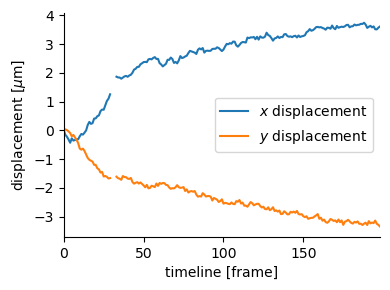

In [3]:
from spt_align import fill_by_shifting_reference_time

displacement = fill_by_shifting_reference_time(df, timeline, displacement_0, nbr_tracks_threshold=50, from_origin=False, extrapolation_kind='linear')
plot_displacement(timeline, displacement)

You can see how at frame 30 we switch from reference time 0 to $T-1$ for the most part. In some places, the displacement cannot be estimated at all (blurry and black frames). To be able to continue at later timepoints without breaking the chain-rule, we extrapolate these missing displacements. 

We can also look for reference times starting at 0. The advantage is that if a reference time of, say, $t_{\textrm{ref}} = 33$ works for all subsequent $T$, we don't have to recompute the displacement profile for all times $t > t_{\textrm{ref}} = 33$. We also avoid most false positive tracks and only focus on the longest ones. The minimum track intersection is still controlled by the parameter `nbr_tracks_threshold`.

  0%|                                                   | 0/199 [00:00<?, ?it/s]

Time 30: No displacement with reference t=0 found... Attempt to change the reference...


 16%|██████▌                                   | 31/199 [00:03<00:18,  9.16it/s]

Time 30: Failed to find a valid reference time...
Time 31: No displacement with reference t=0 found... Attempt to change the reference...
Time 31: Failed to find a valid reference time...
Time 32: No displacement with reference t=0 found... Attempt to change the reference...


100%|█████████████████████████████████████████| 199/199 [00:03<00:00, 55.27it/s]

Time 32: Failed to find a valid reference time...


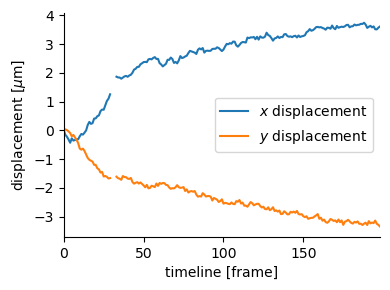

In [4]:
from spt_align import fill_by_shifting_reference_time

displacement = fill_by_shifting_reference_time(df, timeline, displacement_0, nbr_tracks_threshold=100, from_origin=True, extrapolation_kind='linear')
plot_displacement(timeline, displacement)

We obtain a similar result in 3 seconds instead of 54 seconds!

# 5) Apply the correction displacement and save

Once we have such a profile of the measured displacement on the images, we can apply an inverse shift to correct for it. As you can see, most displacements here are much lower than the pixel size (`PxToUm` = 1), which makes applying the shift very tricky. 

We propose to do it in Fourier space, where the manipulation of wavelength makes a tiny shift less prone to artefacts and rounding errors. 

In the following we call the function `align_frames` where you can pass an output folder to save the aligned stack in the disk.

In [5]:
from spt_align import align_frames

stack = align_frames(frames, displacement, PxToUm=PxToUm, output_dir="output")

We can reload the original stack to compare the results:

In [6]:
stack_raw = locate_frames(os.sep.join(['..','data','images']),load=True)

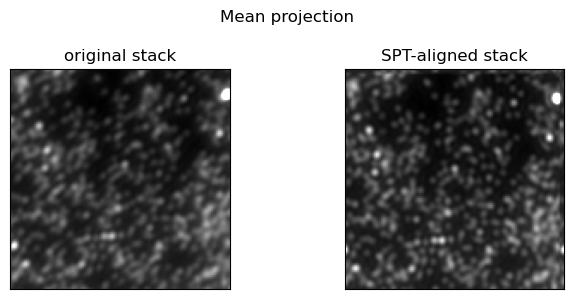

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].imshow(np.mean(stack_raw,axis=0),cmap='gray',vmax=1300)
ax[1].imshow(np.mean(stack,axis=0),cmap='gray',vmax=1300)
ax[0].set_title('original stack')
ax[1].set_title('SPT-aligned stack')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.suptitle('Mean projection')
plt.tight_layout()
plt.show()

# 6) Quality check: displacement profile of the corrected stack

We can now use the aligned stack with TrackMate to retrack the spots and check that we have indeed corrected the shift.

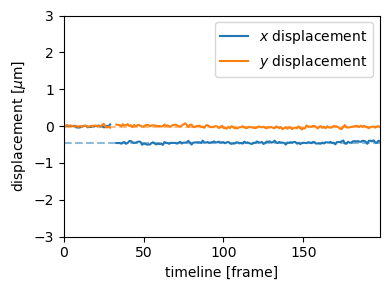

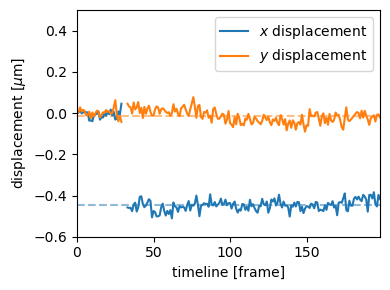

In [8]:
df_post = load_tracks(os.sep.join(['..','data','post-correction-tracking-corrupt.csv']))
frames = locate_frames(os.sep.join(['..','data','images']))
timeline = estimate_timeline(frames, df)
PxToUm = 1

displacement = estimate_displacement(df_post, timeline, reference_time=0, nbr_tracks_threshold=30)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_ylim(-3,3)
ax.hlines(np.mean(displacement[33:,0]),0,max(timeline),linestyle='--',alpha=0.5,zorder=0,color="tab:blue")
ax.hlines(np.mean(displacement[33:,1]),0,max(timeline),linestyle='--',alpha=0.5,zorder=0,color="tab:orange")
plot_displacement(timeline, displacement, ax=ax)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_ylim(-0.6,0.5)
ax.hlines(np.mean(displacement[33:,0]),0,max(timeline),linestyle='--',alpha=0.5,zorder=0,color="tab:blue")
ax.hlines(np.mean(displacement[33:,1]),0,max(timeline),linestyle='--',alpha=0.5,zorder=0,color="tab:orange")
plot_displacement(timeline, displacement, ax=ax)

As you can see, with the corrupt data, we achieve a good alignment in part: before and after the frame for which we had no alignment information due to the truncated tracks. The extrapolation method is at fault here as a poor extrapolation will create such a shift. 

To compare, we can use the good trajectory set and redo all the steps:

In [9]:
df = load_tracks(os.sep.join(['..','data','tracks.csv']))
frames = locate_frames(os.sep.join(['..','data','images']))
timeline = estimate_timeline(frames, df)
PxToUm = 1

displacement = estimate_displacement(df, timeline, reference_time=0, nbr_tracks_threshold=30)
displacement = fill_by_shifting_reference_time(df, timeline, displacement, nbr_tracks_threshold=30, from_origin=True)
align_frames(frames, displacement, PxToUm=PxToUm, output_dir="output_clean",return_stack=False)

  0%|                                                   | 0/199 [00:00<?, ?it/s]

Time 31: No displacement with reference t=0 found... Attempt to change the reference...


100%|█████████████████████████████████████████| 199/199 [00:18<00:00, 10.75it/s]

Time 31: Failed to find a valid reference time...


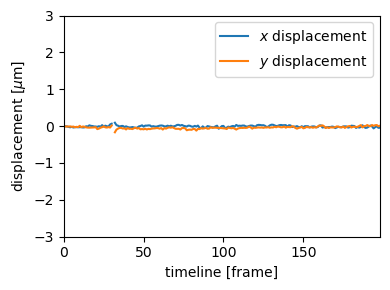

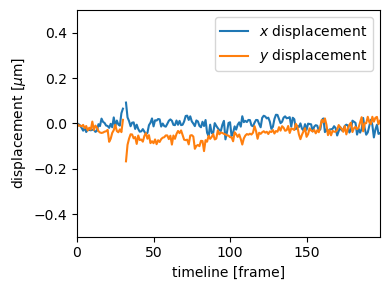

In [10]:
df_post = load_tracks(os.sep.join(['..','data','post-correction-tracking-clean.csv']))
frames = locate_frames(os.sep.join(['..','data','images']))
timeline = estimate_timeline(frames, df)
PxToUm = 1

displacement = estimate_displacement(df_post, timeline, reference_time=0, nbr_tracks_threshold=30)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_ylim(-3,3)
plot_displacement(timeline, displacement, ax=ax)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_ylim(-0.5,0.5)
plot_displacement(timeline, displacement, ax=ax)

As before we achive a correction that limits the shift to less than 20 \% of a pixel per frame.